# Multi-Agent Experiments with Trackers

This notebook demonstrates how to run experiments with the `MultiAgentCodenamesExperiment` class and use different trackers to collect data.

## Overview

The experiment framework provides:
- **MultiAgentCodenamesExperiment**: Run multiple games with policies and track results
- **Trackers**: Callback-based data collection (Summary, Episode, Trajectory)
- **Parameter sweeps**: Test multiple configurations systematically

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path

['/Users/ckausik/.pyenv/versions/3.13.6/lib/python313.zip',
 '/Users/ckausik/.pyenv/versions/3.13.6/lib/python3.13',
 '/Users/ckausik/.pyenv/versions/3.13.6/lib/python3.13/lib-dynload',
 '',
 '/Users/ckausik/.pyenv/versions/py313/lib/python3.13/site-packages',
 '/Users/ckausik/Documents/GitHub/codenames-bot',
 '/var/folders/7y/m7c5pl812yb6x0__xx22cvrw0000gn/T/tmpdnj8o12b',
 '/Users/ckausik/Documents/GitHub/codenames-bot']

In [14]:

from experiments import (
    MultiAgentCodenamesExperiment,
    SummaryTracker,
    EpisodeTracker,
    TrajectoryTracker
)
from envs.word_batch_env import WordBatchEnv
from agents.spymaster import RandomSpymaster, EmbeddingSpymaster, SpymasterParams
from agents.guesser import RandomGuesser, EmbeddingGuesser, GuesserParams

## 1. Creating an Experiment

The experiment takes an `env_factory` function that creates environments given a seed.

In [15]:
# Define environment factory
def make_env(seed):
    return WordBatchEnv(batch_size=8, seed=seed)  # 8 games in parallel

# Create experiment
exp = MultiAgentCodenamesExperiment(
    env_factory=make_env,
    max_turns=50
)

print("Experiment created!")

Experiment created!


## 2. Defining Policies

Policies are functions that map observations to actions. We create a policy map with all four agents.

In [16]:
# Create agents
red_spy = RandomSpymaster(team="red")
red_guess = RandomGuesser(team="red")
blue_spy = RandomSpymaster(team="blue")
blue_guess = RandomGuesser(team="blue")

# Create policy map
policy_map = {
    "red_spy": lambda obs: red_spy.get_clue(obs),
    "red_guess": lambda obs: red_guess.get_guess(obs),
    "blue_spy": lambda obs: blue_spy.get_clue(obs),
    "blue_guess": lambda obs: blue_guess.get_guess(obs),
}

print("Policy map created!")

Policy map created!


## 3. Using SummaryTracker

The `SummaryTracker` computes aggregate statistics (win rates, average rewards) with O(1) memory.

In [17]:
# Run games with summary tracker
summary_tracker = SummaryTracker()

results = exp.run_games(
    policy_map=policy_map,
    n_games=100,
    tracker=summary_tracker,
    seed=42,
    verbose=True
)

print("\n=== Summary Results ===")
print(f"Total games: {results['total_games']}")
print(f"Red win rate: {results['red_win_rate']:.2%}")
print(f"Blue win rate: {results['blue_win_rate']:.2%}")
print(f"Draw rate: {1 - results['red_win_rate'] - results['blue_win_rate']:.2%}")
print(f"Average turns: {results['avg_turns']:.1f}")

print("\n=== Average Rewards Per Agent ===")
for agent_id, avg_reward in results['rewards_per_agent'].items():
    std_reward = results['reward_std_per_agent'][agent_id]
    print(f"{agent_id}: {avg_reward:.2f} ± {std_reward:.2f}")

Completed 8/100 games
Completed 16/100 games
Completed 24/100 games
Completed 32/100 games
Completed 40/100 games
Completed 48/100 games
Completed 56/100 games
Completed 64/100 games
Completed 72/100 games
Completed 80/100 games
Completed 88/100 games
Completed 96/100 games
Completed 100/100 games

=== Summary Results ===
Total games: 104
Red win rate: 49.04%
Blue win rate: 50.96%
Draw rate: 0.00%
Average turns: 7.5

=== Average Rewards Per Agent ===
red_spy: -1.04 ± 4.29
red_guess: -7.22 ± 10.58
blue_spy: -0.21 ± 2.00
blue_guess: -7.58 ± 11.11


## 4. Using EpisodeTracker

The `EpisodeTracker` stores per-episode data (winner, rewards, turns) with O(n_games) memory.

In [18]:
# Run games with episode tracker
episode_tracker = EpisodeTracker()

episodes = exp.run_games(
    policy_map=policy_map,
    n_games=50,
    tracker=episode_tracker,
    seed=100
)

print(f"Collected {len(episodes)} episodes")
print("\nFirst episode:")
print(f"  Episode index: {episodes[0]['episode_idx']}")
print(f"  Winner: {episodes[0]['winner']}")
print(f"  Turns: {episodes[0]['turns']}")
print(f"  Red spy reward: {episodes[0]['total_rewards']['red_spy']:.2f}")

Collected 7 episodes

First episode:
  Episode index: 0
  Winner: 0
  Turns: 2
  Red spy reward: -2.00


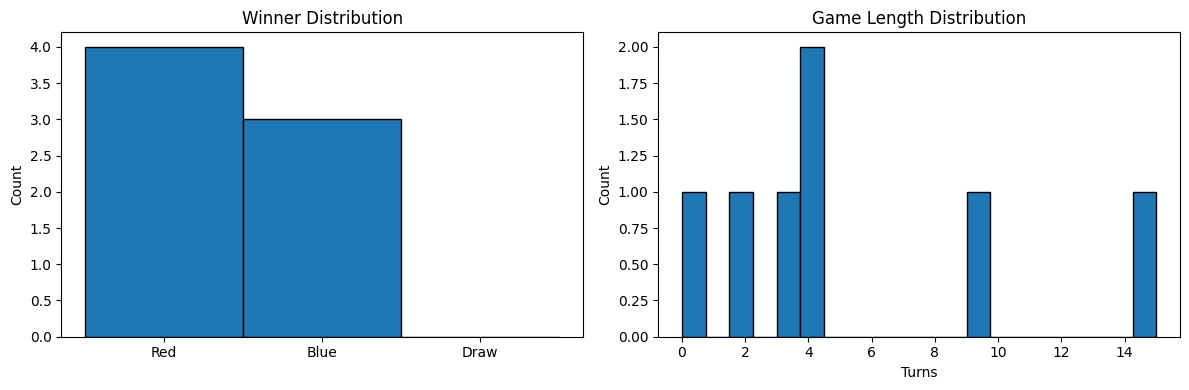

In [19]:
# Analyze episode distribution
winners = [ep['winner'] for ep in episodes]
turns = [ep['turns'] for ep in episodes]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Winner distribution
axes[0].hist(winners, bins=[-0.5, 0.5, 1.5, 2.5], edgecolor='black')
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['Red', 'Blue', 'Draw'])
axes[0].set_ylabel('Count')
axes[0].set_title('Winner Distribution')

# Turn distribution
axes[1].hist(turns, bins=20, edgecolor='black')
axes[1].set_xlabel('Turns')
axes[1].set_ylabel('Count')
axes[1].set_title('Game Length Distribution')

plt.tight_layout()
plt.show()

## 5. Using TrajectoryTracker

The `TrajectoryTracker` stores full step-by-step data with O(n_games × n_steps) memory.

In [20]:
# Run a few games with trajectory tracker
trajectory_tracker = TrajectoryTracker(
    store_observations=True,
    store_actions=True
)

trajectories = exp.run_games(
    policy_map=policy_map,
    n_games=5,
    tracker=trajectory_tracker,
    seed=200
)

print(f"Collected {len(trajectories)} trajectories")
print("\nFirst trajectory:")
print(f"  Episode index: {trajectories[0]['episode_idx']}")
print(f"  Winner: {trajectories[0]['winner']}")
print(f"  Turns: {trajectories[0]['turns']}")
print(f"  Trajectory length: {len(trajectories[0]['trajectory'])} steps")

# Inspect first step
step_0 = trajectories[0]['trajectory'][0]
print("\nFirst step data:")
print(f"  Step: {step_0['step']}")
print(f"  Rewards: {step_0['rewards']}")
print(f"  Has observations: {'observations' in step_0}")
print(f"  Has actions: {'actions' in step_0}")

Collected 1 trajectories

First trajectory:
  Episode index: 0
  Winner: 0
  Turns: 9
  Trajectory length: 24 steps

First step data:
  Step: 0
  Rewards: {'red_spy': array([0., 0., 0., 0., 0., 0., 0., 0.]), 'red_guess': array([0., 0., 0., 0., 0., 0., 0., 0.]), 'blue_spy': array([0., 0., 0., 0., 0., 0., 0., 0.]), 'blue_guess': array([0., 0., 0., 0., 0., 0., 0., 0.])}
  Has observations: True
  Has actions: True


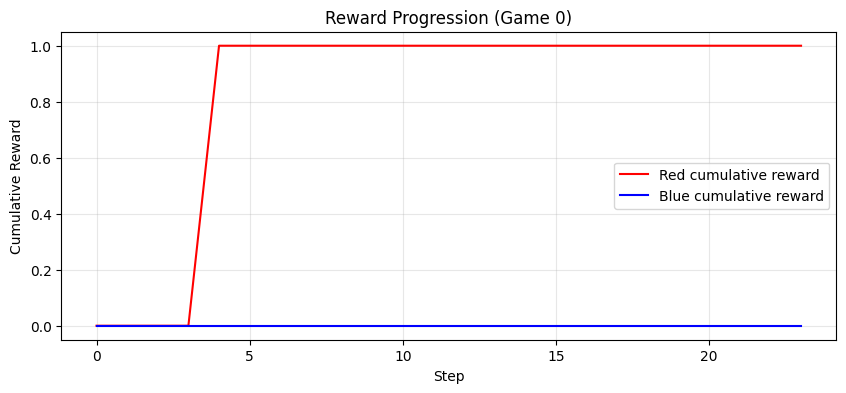

In [21]:
# Plot reward progression for first game
trajectory = trajectories[0]['trajectory']
steps = [s['step'] for s in trajectory]
red_spy_rewards = [s['rewards']['red_spy'][0] for s in trajectory]
blue_spy_rewards = [s['rewards']['blue_spy'][0] for s in trajectory]

plt.figure(figsize=(10, 4))
plt.plot(steps, np.cumsum(red_spy_rewards), label='Red cumulative reward', color='red')
plt.plot(steps, np.cumsum(blue_spy_rewards), label='Blue cumulative reward', color='blue')
plt.xlabel('Step')
plt.ylabel('Cumulative Reward')
plt.title('Reward Progression (Game 0)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Tracker Accumulation

Trackers can accumulate data across multiple `run_games` calls.

In [22]:
# Create tracker
accumulated_tracker = SummaryTracker()

# Run multiple batches
exp.run_games(policy_map=policy_map, n_games=50, tracker=accumulated_tracker, seed=300)
exp.run_games(policy_map=policy_map, n_games=30, tracker=accumulated_tracker, seed=400)
exp.run_games(policy_map=policy_map, n_games=20, tracker=accumulated_tracker, seed=500)

# Get accumulated results
results = accumulated_tracker.get_results()
print(f"Total games accumulated: {results['total_games']}")
print(f"Red win rate: {results['red_win_rate']:.2%}")

Total games accumulated: 112
Red win rate: 49.11%


## 7. Comparing Agent Strategies

Let's compare random vs embedding-based agents.

In [23]:
# Check if embedding agents are available
try:
    # Random vs Random
    random_policy_map = {
        "red_spy": lambda obs: RandomSpymaster(team="red").get_clue(obs),
        "red_guess": lambda obs: RandomGuesser(team="red").get_guess(obs),
        "blue_spy": lambda obs: RandomSpymaster(team="blue").get_clue(obs),
        "blue_guess": lambda obs: RandomGuesser(team="blue").get_guess(obs),
    }
    
    random_tracker = SummaryTracker()
    random_results = exp.run_games(
        policy_map=random_policy_map,
        n_games=50,
        tracker=random_tracker,
        seed=600
    )
    
    # Embedding vs Embedding
    embedding_red_spy = EmbeddingSpymaster(team="red", params=SpymasterParams(n_candidate_clues=20, seed=42))
    embedding_red_guess = EmbeddingGuesser(team="red", params=GuesserParams(similarity_threshold=0.0, seed=42))
    embedding_blue_spy = EmbeddingSpymaster(team="blue", params=SpymasterParams(n_candidate_clues=20, seed=43))
    embedding_blue_guess = EmbeddingGuesser(team="blue", params=GuesserParams(similarity_threshold=0.0, seed=43))
    
    embedding_policy_map = {
        "red_spy": lambda obs: embedding_red_spy.get_clue(obs),
        "red_guess": lambda obs: embedding_red_guess.get_guess(obs),
        "blue_spy": lambda obs: embedding_blue_spy.get_clue(obs),
        "blue_guess": lambda obs: embedding_blue_guess.get_guess(obs),
    }
    
    embedding_tracker = SummaryTracker()
    embedding_results = exp.run_games(
        policy_map=embedding_policy_map,
        n_games=50,
        tracker=embedding_tracker,
        seed=600  # Same seed for fair comparison
    )
    
    # Compare results
    print("=== Strategy Comparison ===")
    print("\nRandom vs Random:")
    print(f"  Average turns: {random_results['avg_turns']:.1f}")
    print(f"  Red spy avg reward: {random_results['rewards_per_agent']['red_spy']:.2f}")
    
    print("\nEmbedding vs Embedding:")
    print(f"  Average turns: {embedding_results['avg_turns']:.1f}")
    print(f"  Red spy avg reward: {embedding_results['rewards_per_agent']['red_spy']:.2f}")
    
except RuntimeError as e:
    print(f"Embedding agents unavailable: {e}")
    print("Install sentence-transformers to compare strategies")

=== Strategy Comparison ===

Random vs Random:
  Average turns: 8.0
  Red spy avg reward: -0.30

Embedding vs Embedding:
  Average turns: 7.5
  Red spy avg reward: 0.02


## 8. Custom Tracker Example

You can create custom trackers by subclassing `GameTracker`.

In [24]:
from experiments.trackers import GameTracker

class AssassinTracker(GameTracker):
    """Track how many games end by hitting the assassin."""
    
    def __init__(self):
        self.total_games = 0
        self.assassin_deaths = 0
        self.agent_ids = None
    
    def on_step(self, step, obs_dict, actions_dict, rewards_dict, dones_dict, infos_dict):
        # Initialize agent IDs
        if self.agent_ids is None:
            self.agent_ids = list(rewards_dict.keys())
    
    def on_episode_end(self, episode_idx, final_infos):
        info = final_infos[self.agent_ids[0]]
        
        # Check if game ended by assassin (winner == 2 means assassin was hit)
        winner = info['winner'][0] if hasattr(info['winner'], '__iter__') else info['winner']
        if winner == 2:
            self.assassin_deaths += 1
        
        self.total_games += 1
    
    def get_results(self):
        return {
            'total_games': self.total_games,
            'assassin_deaths': self.assassin_deaths,
            'assassin_rate': self.assassin_deaths / self.total_games if self.total_games > 0 else 0
        }

# Use custom tracker
assassin_tracker = AssassinTracker()
exp.run_games(policy_map=policy_map, n_games=100, tracker=assassin_tracker, seed=700)

results = assassin_tracker.get_results()
print(f"\nAssassin deaths: {results['assassin_deaths']}/{results['total_games']} ({results['assassin_rate']:.1%})")


Assassin deaths: 0/13 (0.0%)


## Summary

You now know how to:
- Create experiments with `MultiAgentCodenamesExperiment`
- Use the three pre-built trackers (Summary, Episode, Trajectory)
- Accumulate data across multiple runs
- Compare different agent strategies
- Create custom trackers

Next notebooks:
- **03_training_single_agent.ipynb**: Train a single agent with RL
- **04_parameter_sweeps.ipynb**: Optimize agent parameters systematically